## Stage 1: Exploratory Data Analysis

# Setup & Data Loading

In [ ]:
# Import needed packages
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from scipy.stats import skew, kurtosis

In [150]:
# Load the preprocessed data
cleaned_data = pd.read_csv('../data/checkpoints/enriched_cleaned_data.csv', delimiter = '|')

In [ ]:
# Set the theme and figisze for a unique plot appearence
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Data Preparation & simple Feature Engineering

In [151]:
# Define a function to convert a string representation of a list to a list datatype
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        print('List conversion failed')
        return []

# Convert the string representations of the lists to the correct "list" datatype
cleaned_data['word_tokens'] = cleaned_data['word_tokens'].apply(string_to_list)
cleaned_data['sentence_tokens'] = cleaned_data['sentence_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_word_tokens'] = cleaned_data['pos_tagged_word_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_sentence_tokens'] = cleaned_data['pos_tagged_sentence_tokens'].apply(string_to_list)
cleaned_data['esg_topics'] = cleaned_data['esg_topics'].apply(string_to_list)

In [172]:
# Add some count features for the analysis
cleaned_data['cnt_word'] = cleaned_data['word_tokens'].apply(len)
cleaned_data['cnt_sentence'] = cleaned_data['sentence_tokens'].apply(len)
cleaned_data['cnt_esg'] = cleaned_data['esg_topics'].apply(len)

# Calculate ratio between words/sentences
cleaned_data['ratio_word_sentence'] = cleaned_data['cnt_word'] / cleaned_data['cnt_sentence']

In [170]:
# Convert date to correct datatype
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Derive year and month to aggregate
cleaned_data['year_month'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y-%m'))
cleaned_data['year'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y'))
cleaned_data['month'] = cleaned_data['date'].apply(lambda x: x.strftime('%m'))

In [173]:
# Check the data with a few samples
cleaned_data.sample(5)

,company,datatype,date,domain,esg_topics,internal,symbol,title,cleaned_content,word_tokens,...,industry,word_amount,sentence_amount,cnt_word,cnt_sentence,cnt_esg,year_month,month,year,ratio_word_sentence
6849,Merck,tech,2022-06-30,healthcareitnews,[Oversight],0,MRK,Dubai Health Authority to pilot value-based he...,dha and its health insurance regulatory bod...,"[dha, health, insurance, regulatory, body, lau...",...,Drug Manufacturers—Specialty & Generic,289,15,289,15,1,2022-06,06,2022,19.266667
10094,Siemens Healthineers,general,2021-10-03,itnonline,"[Social, Environment]",0,SHL,Clinical Applications of FFR-CT,computed tomography ffr ct is still in the...,"[computed, tomography, ffr, ct, still, early, ...",...,Diagnostics & Research,1125,73,1125,73,2,2021-10,10,2021,15.410959
9171,Siemens,general,2021-10-07,ecochunk,"[ValueChain, EnergyEfficiency]",0,SIE,Digitalization of Power Distribution Market by...,". in the digital trend, more and more industri...","[digital, trend, industry, realized, benefit, ...",...,Specialty Industrial Machinery,474,22,474,22,2,2021-10,10,2021,21.545455
8357,SAP,general,2022-02-18,businesswire,[LaborManagement],0,SAP,US Logistic & Supply Chain Systems Market Rese...,dublin business wire the logistic ...,"[dublin, business, wire, logistic, supply, cha...",...,Software—Application,511,17,511,17,1,2022-02,02,2022,30.058824
1960,BMW,general,2022-11-16,greenprophet,"[Pollution, Environment, AirPollution, FossilF...",0,BMW,"Green Prophet, Author at Green Prophet",window.dojorequire mojo signup forms lo...,"[windowdojorequire, mojo, signup, form, loader...",...,Auto Manufacturers,269,20,269,20,5,2022-11,11,2022,13.450000


# General Descriptive Analysis

In [194]:
# Define a function to plot histograms and boxplots
def plot_basic_hist_and_box(column, data):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True)
    plt.title(f"Histogram of {column}")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

# Calculate measures of central tendency, skewness, and kurtosis
def calculate_basic_statistical_properties(column, data):
    mean = data[column].mean()
    median = data[column].median()
    mode = data[column].mode().values[0]
    skewness = skew(data[column].dropna())
    kurt = kurtosis(data[column].dropna())
    
    print(f"Mean: {round(mean,2)}\nMedian: {round(median,2)}\nMode: {round(mode,2)}\nSkewness: {round(skewness,2)}\nKurtosis: {round(kurt,2)}")

# Measures of dispersion (range, interquartile range, variance, and standard deviation)
def calulate_dispersion_measures(column, data):
    min_value = data[column].min()
    max_value = data[column].max()
    range_value = max_value - min_value
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    variance = data[column].var()
    std_dev = data[column].std()
    
    print(f"Range: {round(range_value,2)}\nInterquartile Range: {round(iqr,2)}\nVariance: {round(variance,2)}\nStandard Deviation: {round(std_dev,2)}")

## Length of Reports by Words

Mean: 956.1
Median: 342.0
Mode: 208
Skewness: 13.78
Kurtosis: 224.27
Range: 127305
Interquartile Range: 338.0
Variance: 25012182.46
Standard Deviation: 5001.22


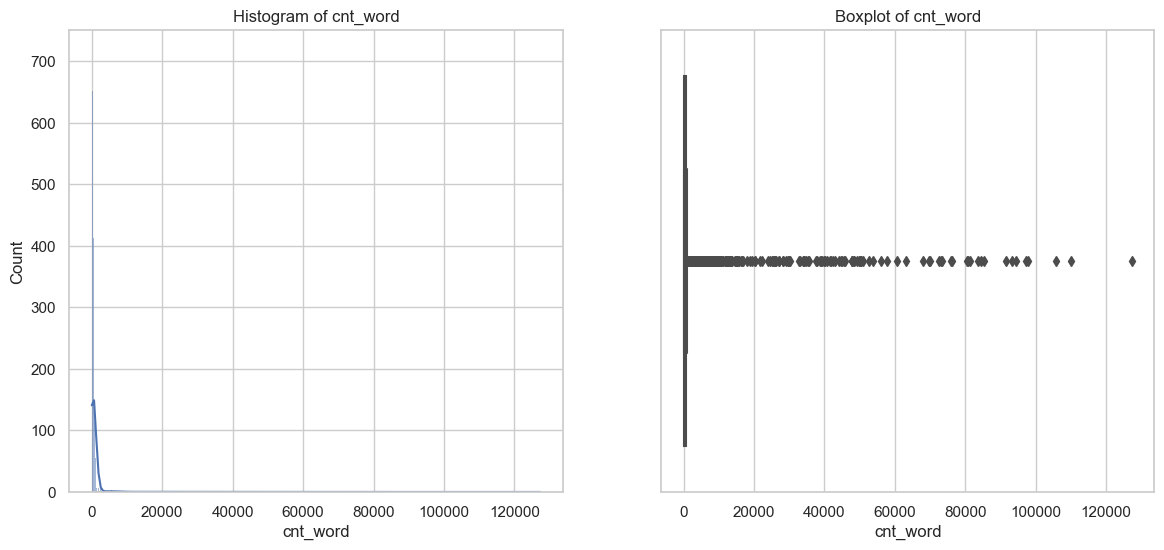

In [195]:
calculate_basic_statistical_properties('cnt_word', cleaned_data)
calulate_dispersion_measures('cnt_word', cleaned_data)
plot_basic_hist_and_box('cnt_word', cleaned_data)

Mean: 64.32
Median: 24.0
Mode: 12
Skewness: 13.83
Kurtosis: 231.13
Range: 8268
Interquartile Range: 26.0
Variance: 101432.22
Standard Deviation: 318.48


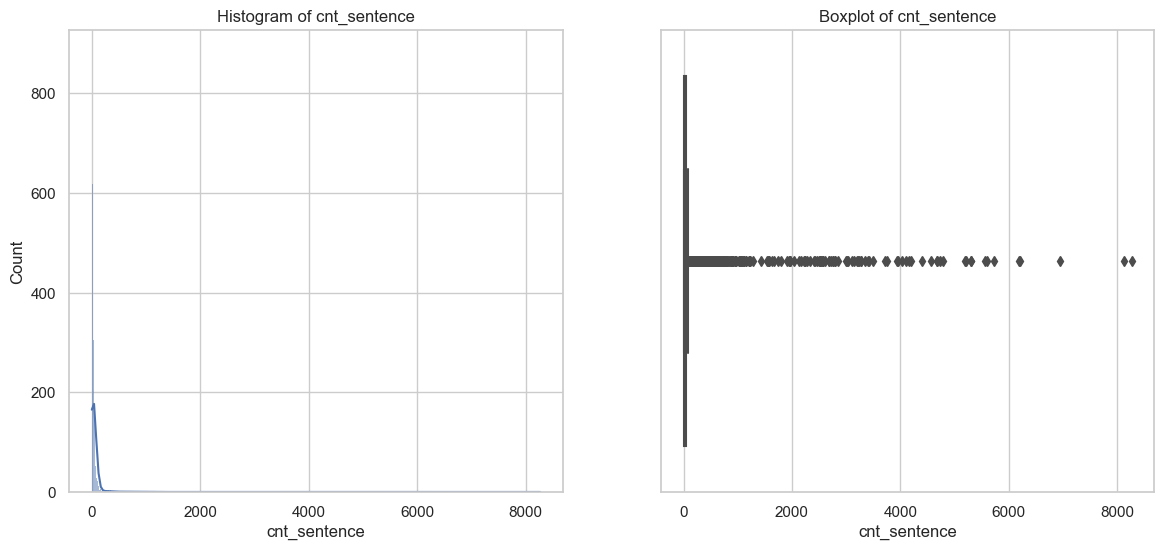

In [196]:
calculate_basic_statistical_properties('cnt_sentence', cleaned_data)
calulate_dispersion_measures('cnt_sentence', cleaned_data)
plot_basic_hist_and_box('cnt_sentence', cleaned_data)

Mean: 597.25
Median: 340.0
Mode: 208
Skewness: 17.15
Kurtosis: 425.48
Range: 63205
Interquartile Range: 332.0
Variance: 2966233.27
Standard Deviation: 1722.28


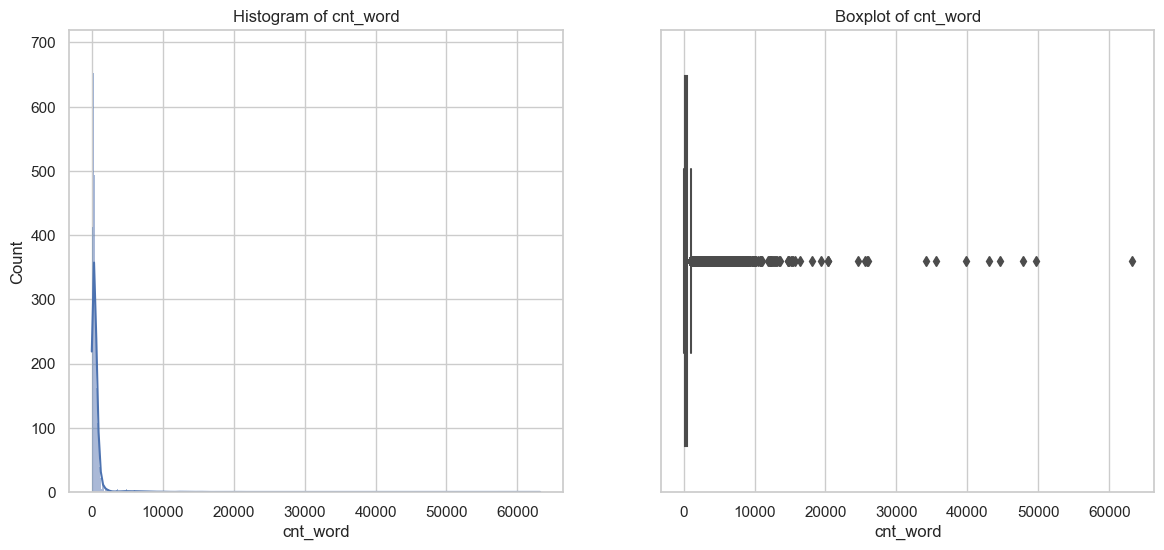

In [197]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 0])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 0])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 0])

Mean: 44263.02
Median: 39235.0
Mode: 2385
Skewness: 0.67
Kurtosis: -0.16
Range: 124920
Interquartile Range: 33849.0
Variance: 803099011.2
Standard Deviation: 28339.0


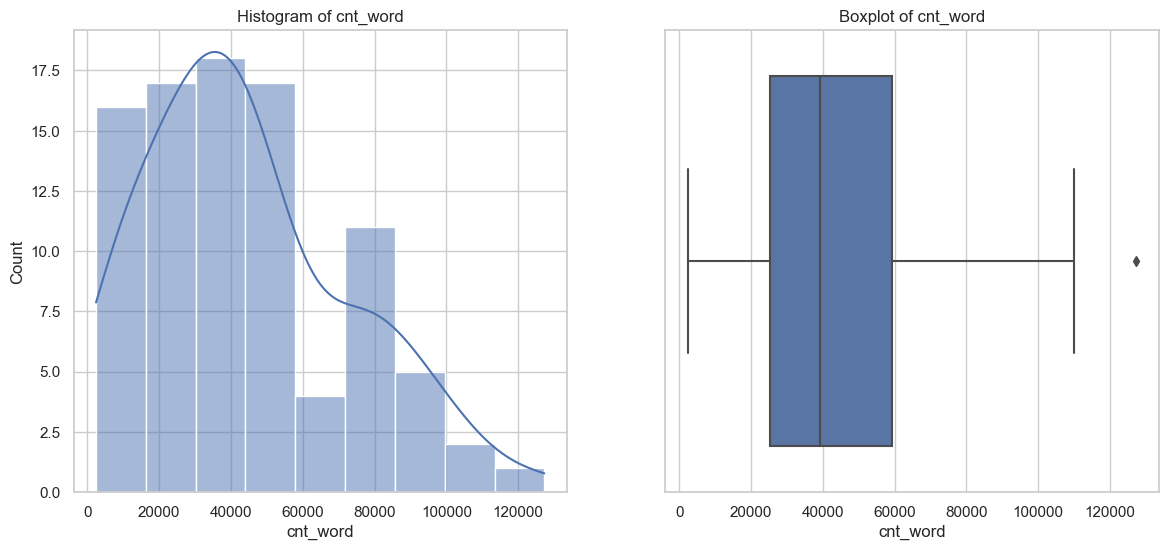

In [198]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 1])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 1])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 1])

In [119]:
cleaned_data.sample(5)

,company,datatype,date,domain,esg_topics,internal,symbol,title,cleaned_content,word_tokens,sentence_tokens,pos_tagged_word_tokens,pos_tagged_sentence_tokens,market_cap_in_usd_b,sector,industry,avg_word_length,year_month
3422,Daimler,general,2022-09-28,greenprophet,"['Boycott', 'Sanction']",0,DAI,Smuggled African elephants at Abu Dhabi Zoo,window.dojorequire mojo signup forms lo...,"['windowdojorequire', 'mojo', 'signup', 'form'...",['windowdojorequire mojo signup forms loader ...,"[('windowdojorequire', 'NN'), ('mojo', 'NN'), ...","[[('windowdojorequire', 'NN'), ('mojo', 'NN'),...",75.72,Consumer Discretionary,Auto Manufacturers,4360,2022-09
142,Adidas,business,2021-03-19,cnbc,"['Privacy', 'ProductLiability']",0,ADS,Peloton CEO says child died in treadmill accid...,", the fitness company's ceo said in a letter p...","['fitness', 'ceo', 'letter', 'posted', 'websit...","[' fitness s ceo letter posted website ', 'let...","[('fitness', 'NN'), ('ceo', 'NN'), ('letter', ...","[[('fitness', 'NN'), ('ceo', 'NN'), ('letter',...",25.77,Consumer Discretionary,Footwear & Accessories,1644,2021-03
6990,Porsche,general,2021-03-17,carmagazine,['EMobility'],0,PAH3,The WEVC Coupe is definitely not an electric P...,"sub 1,000kg, 160bhp original ev platform s...","['sub', '000kg', '160bhp', 'original', 'ev', '...","['sub original ev platform starts nope ', 'wr...","[('sub', 'NN'), ('000kg', 'CD'), ('160bhp', 'C...","[[('sub', 'VBD'), ('original', 'JJ'), ('ev', '...",16.65,Consumer Discretionary,Auto Manufacturers,2850,2021-03
2962,Continental,general,2023-02-17,taiwannews.com,"['ConsumerBehavior', 'Environment']",0,CON,"Global Car Safety Market Trends, Share, Value,...",. this report provides a 360 degree view of th...,"['report', 'provides', 'degree', 'view', 'mark...","['', 'report provides degree view market incl...","[('report', 'NN'), ('provides', 'VBZ'), ('degr...","[[], [('report', 'NN'), ('provides', 'VBZ'), (...",13.27,Consumer Discretionary,Auto Parts,5822,2023-02
4361,Deutsche Boerse,business,2023-02-20,morningstar,"['Transparency', 'Privacy']",0,DB1,Commerzbank to Join DAX Amid Linde Delisting,'s blue chip dax index after shareholders of t...,"['blue', 'chip', 'dax', 'index', 'shareholder'...",['s blue chip dax index shareholders chemical ...,"[('blue', 'JJ'), ('chip', 'NN'), ('dax', 'JJ')...","[[('blue', 'JJ'), ('chip', 'NN'), ('dax', 'JJ'...",31.43,Financials,Financial Data & Stock Exchanges,1992,2023-02


# Text Specific Analysis

### Datatype (Report Type) Amount

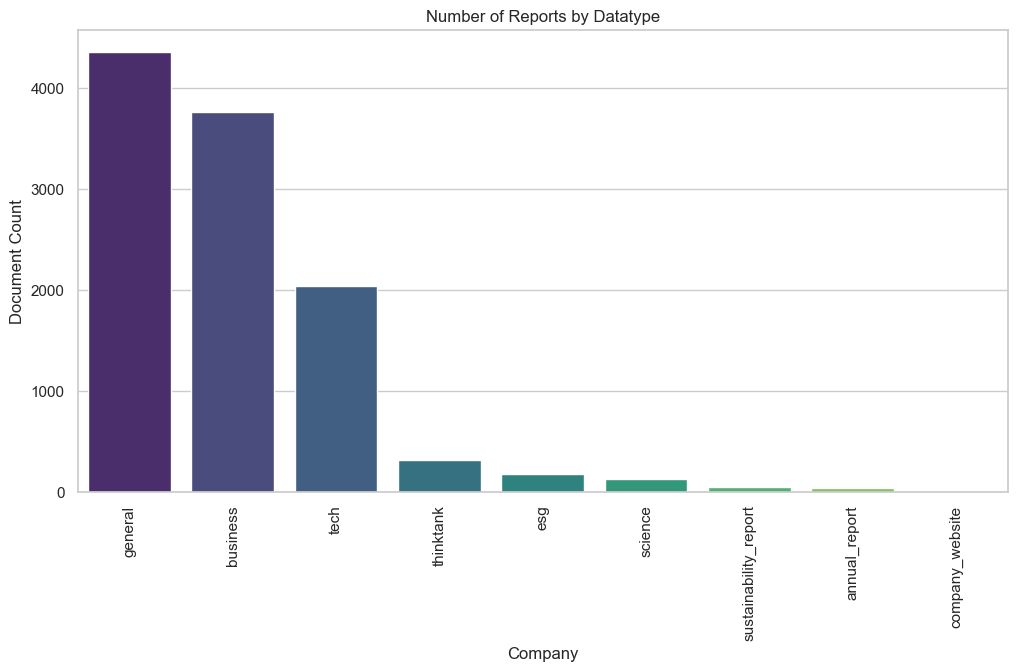

In [199]:
count_datatype = cleaned_data['datatype'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette="viridis")
plt.title("Number of Reports by Datatype")
plt.xlabel("Company")
plt.ylabel("Document Count")
plt.xticks(rotation=90)
plt.show()

### Number of Documents by Company

### Characteristic Words by Company

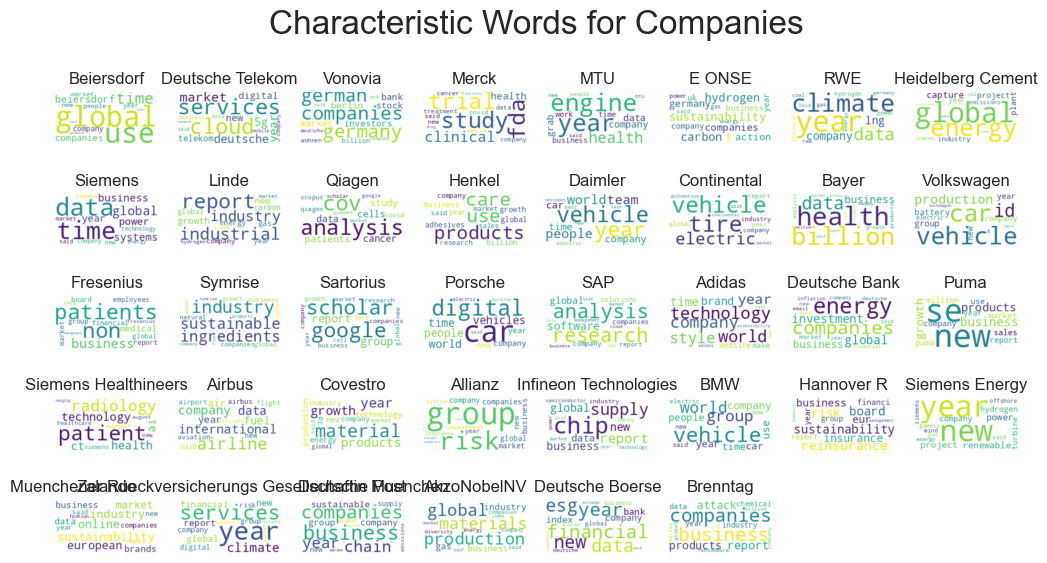

In [154]:
def characteristic_words_by_company(company, data, n=15):
    company_data = data[data['company'] == company]
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    X = vectorizer.fit_transform(company_data['cleaned_content'])
    top_n_indices = np.argsort(X.toarray().sum(axis=0))[-n:]
    top_n_words = np.array(vectorizer.get_feature_names_out())[top_n_indices]
    return top_n_words

companies = cleaned_data['company'].unique()
for company in companies:
    characteristic_words = characteristic_words_by_company(company, cleaned_data)
    # print(f"{company}: {', '.join(characteristic_words)}")

def plot_wordcloud_subplot(ax, company, data, n=15):
    characteristic_words = characteristic_words_by_company(company, data, n)
    wordcloud = WordCloud(width=200, height=100, background_color="white", colormap="viridis").generate(" ".join(characteristic_words))
    
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{company}")

companies = cleaned_data['company'].unique()
n_companies = len(companies)

fig, axes = plt.subplots(nrows=int(np.ceil(n_companies/8)), ncols=8)
axes = axes.ravel()

for i, company in enumerate(companies):
    plot_wordcloud_subplot(axes[i], company, cleaned_data)

# Remove unused subplots
for i in range(n_companies, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Characteristic Words for Companies", fontsize=24)
plt.subplots_adjust(wspace=0, hspace=0) # Adjust the horizontal and vertical spacing between subplots
plt.tight_layout()
plt.show()

### Word Token Type

### N-Gram Exploration

## Intern vs. External Report

## Sector & Industry Analysis

## Sentiment Analysis / Polarity

In [ ]:
# nltk.sentiment.vader SentimentIntensityAnalyzer

# textblob sentiment.polarity

## ESG Topic Exploration

### ESG Topic Distribution over Time

In [ ]:
cleaned_data['avg_word_length'] = cleaned_data['word_tokens'].apply(len)
avg_length_by_datatype = cleaned_data.groupby('datatype')['avg_word_length'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_length_by_datatype.index, y=avg_length_by_datatype.values, palette="viridis")
plt.title("Average Report Length by Datatype")
plt.xlabel("Datatype")
plt.ylabel("Average Report Length")
plt.show()

In [ ]:
doc_count_by_company = cleaned_data['company'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=doc_count_by_company.index, y=doc_count_by_company.values, palette="viridis")
plt.title("Number of Reports by Company")
plt.xlabel("Company")
plt.ylabel("Document Count")
plt.xticks(rotation=90)
plt.show()

/var/folders/9k/tdnv785s1hx8x68mq3f94lzw0000gn/T/ipykernel_99806/3921888490.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


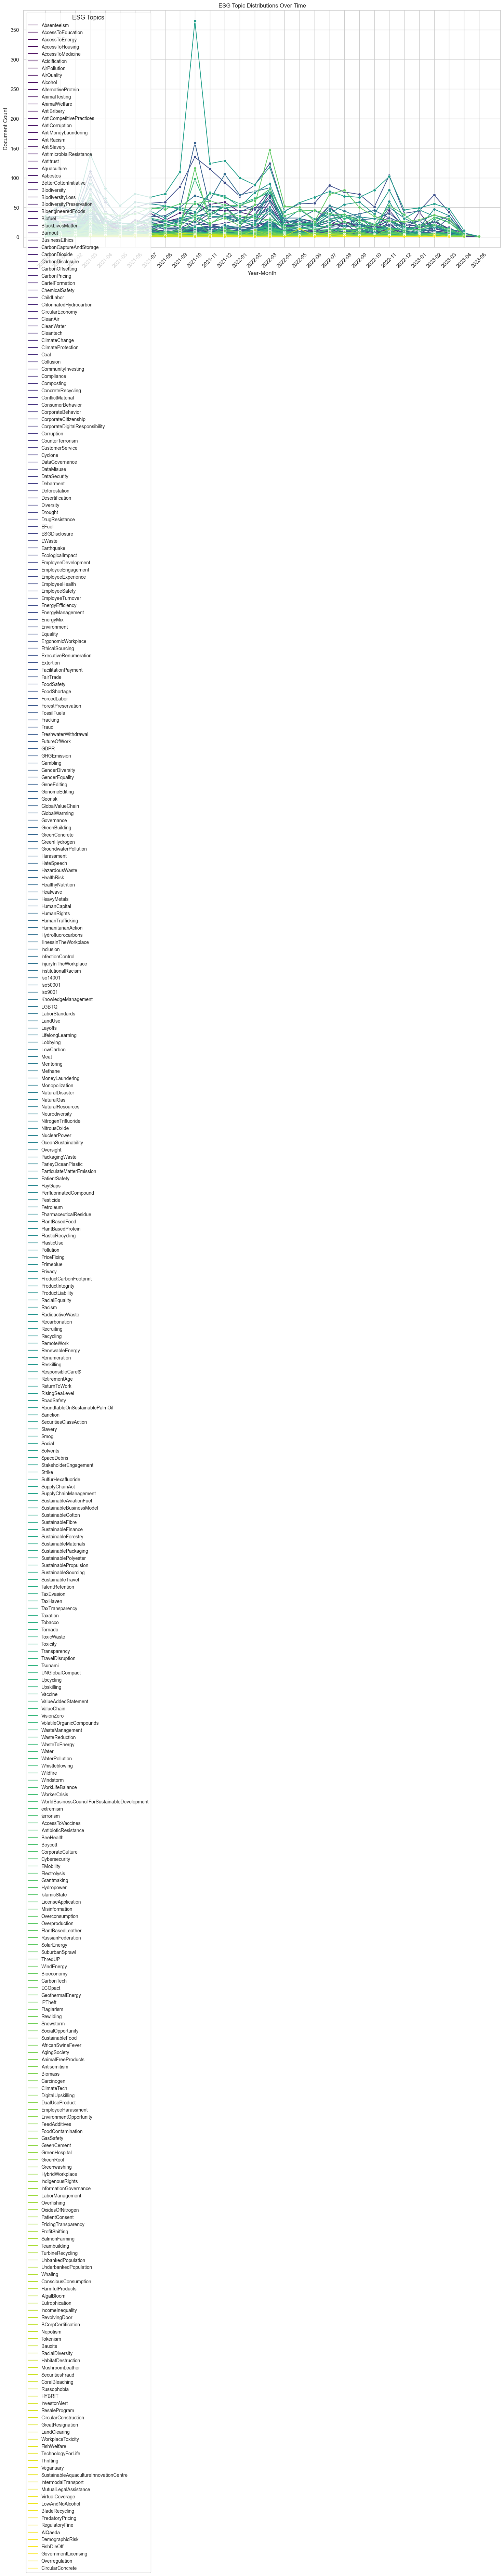

In [162]:
topic_timeseries = cleaned_data.explode('esg_topics').groupby(['year_month', 'esg_topics']).size().reset_index(name='count')

plt.figure(figsize=(18, 9))
sns.lineplot(data=topic_timeseries, x='year_month', y='count', hue='esg_topics', marker='o', palette='viridis')
plt.title("ESG Topic Distributions Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Document Count")
plt.xticks(rotation=45)
plt.legend(title="ESG Topics", title_fontsize='13', loc='upper left', fontsize='10')
plt.tight_layout()
plt.show()